Everything in this notebook is my work for the fourth exercise of the AML course.

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Preprocessing of the datasets

Occupancy Detection Dataset

(1) Load the dataset

In [316]:
occupancy_detection_data = pd.read_csv("occupancy_detection/datatraining.txt")
occupancy_detection_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


(2) Check if any non-numeric values. If any, convert them to numeric values.

In [317]:
occupancy_detection_data.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [318]:
unique_dates = occupancy_detection_data['date'].unique()
len(unique_dates)

8143

Only the date column is non-numeric. I will convert it to Unix timestamp, so I can use it later in the classification process. One-hot encoding is not an option, because each value is unique, so we will have unnecessary a lot of columns. The hashmap is a good idea if we have limited unique element is the column, which isn't the case here (out of 8143 samples, 8143 are unique).

In [319]:
occupancy_detection_data['date'] = pd.to_datetime(occupancy_detection_data['date'])
occupancy_detection_data['date'] = occupancy_detection_data['date'].astype('int64') // 10**9

occupancy_detection_data.dtypes

date               int64
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

Like this, one can observe the general trend over time better. Other cases could allow the data to be interpreted as individual extracted components (like day, week, year) to capture seasonal and weekly patterns.

(3) Remove null / NaN values

In [320]:
occupancy_detection_data.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

The loaded part of the dataset has no missing values.

(4) Add the bias and split the data 80/20

In [321]:
np.random.seed(1337)

def split_data(Xdata, Ydata, train_percent):
    split_index = int(train_percent * len(Xdata))

    indices = np.arange(len(Xdata))
    np.random.shuffle(indices)

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    Xtrain = Xdata.iloc[train_indices].reset_index(drop=True)
    Ytrain = Ydata.iloc[train_indices].reset_index(drop=True)
    Xtest = Xdata.iloc[test_indices].reset_index(drop=True)
    Ytest = Ydata.iloc[test_indices].reset_index(drop=True)
    
    return Xtrain, Ytrain, Xtest, Ytest

Function to normalize the training set and the test set using Z-Score

In [322]:
def standardize_data(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_standardized = (X_train - mean) / std
    X_test_standardized = (X_test - mean) / std
    return X_train_standardized, X_test_standardized


In [323]:
occupancy_detection_Xdata = occupancy_detection_data.drop(['Occupancy'], axis=1)
occupancy_detection_Ydata = occupancy_detection_data['Occupancy']

occupancy_detection_Xtrain, occupancy_detection_Ytrain, occupancy_detection_Xtest, occupancy_detection_Ytest = split_data(occupancy_detection_Xdata, occupancy_detection_Ydata, 0.8)

bank_Xtrain, bank_Xtest = standardize_data(occupancy_detection_Xtrain, occupancy_detection_Xtest)

I add the bias to the training set and the test set

In [324]:
N = occupancy_detection_Xtrain.shape[0]
occupancy_detection_Xtrain = np.c_[np.ones(N), occupancy_detection_Xtrain]
N = occupancy_detection_Xtest.shape[0]
occupancy_detection_Xtest = np.c_[np.ones(N), occupancy_detection_Xtest]

I don't use the datatest.txt and datatest2.txt, because the task explicitly says to split the data 80/20. I pick the largest dataset and split it. However, it would be also possible to use datatest.txt and datatest2.txt for testing.

Bank Marketing Dataset

(1) Load the data

In [325]:
bank_data = pd.read_csv("bank/bank.csv", delimiter=";")
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


(2) Convert non-numeric values to numeric

In [326]:
bank_data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [327]:
unique_jobs = bank_data['job'].unique()
print("Number of unique jobs:", len(unique_jobs))

Number of unique jobs: 12


Since most of the elements in the columns aren't unique, I decided just to encode them and not to produce unnecessary overhead by adding one-hot encoding or hashmap.

The column "pdays" contains values that may cause problems (i.e. the value -1). I create a new column named "previously_contacted" and replace the -1 values with zero, so we can still distinguish, which people were contacted and also have no negative values.

In [328]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

for feature in categorical_features:
    bank_data[feature] = pd.Categorical(bank_data[feature]).codes

bank_data['previously_contacted'] = np.where(bank_data['pdays'] != -1, 1, 0)

bank_data['pdays'] = bank_data['pdays'].replace(-1, 0)

bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,previously_contacted
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,0,0,3,0,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0,1
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0,1
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,0,0,3,0,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,0,0,3,0,0


(3) Remove null / NaN values

In [329]:
bank_data.isnull().sum()

age                     0
job                     0
marital                 0
education               0
default                 0
balance                 0
housing                 0
loan                    0
contact                 0
day                     0
month                   0
duration                0
campaign                0
pdays                   0
previous                0
poutcome                0
y                       0
previously_contacted    0
dtype: int64

No column contains missing values, so we have nothing to remove.

(4) Add the bias and split the data 

In [330]:
bank_Xdata = bank_data.drop(['y'], axis=1)
bank_Ydata = bank_data['y']

bank_Xtrain, bank_Ytrain, bank_Xtest, bank_Ytest = split_data(bank_Xdata, bank_Ydata, 0.8)

bank_Xtrain, bank_Xtest = standardize_data(bank_Xtrain, bank_Xtest)

bank_Ytrain = bank_Ytrain.values
bank_Ytest = bank_Ytest.values

N = bank_Xtrain.shape[0]
bank_Xtrain = np.c_[np.ones(N), bank_Xtrain]
N = bank_Xtest.shape[0]
bank_Xtest = np.c_[np.ones(N), bank_Xtest]

# Gradient-based Linear Classification

The log-likelihood function for logistic regression is defined as:

$$E(w) = \log p(\bold{y} | \bold{w}, \bold{X}) = \sum_{i=1}^N y_{i}\log \sigma(\bold{w}^Tx_{i}) + (1-y_{i})\log(1-\sigma(\bold{w}^{T}x_{i}))$$

, where $\bold{w}$ is the weight vector, $x_{i}$ is a single data point with all its features, $y_{i}$ is the corresponding class ($y_{i} \in \{0,1\} $) and $\sigma(z)$ is the sigmoid function defined below. The log-likelihood function is concave. To optimize it we should either take the negative log-likelihood (and make it convex) and then optimize it with gradient descent or use gradient ascent directly with the log likelihood. This will produce the same result (for the argument). In this notebook, I do both.

Sigmoid function:
$$ \sigma(z) = \frac{1}{1 + e^{-z}}$$

#### **Why is log-likelihood concave?**

Knowing how the graph of the sigmoid function looks like we can say its neither concave nor convex, because for $z \leq$ 0 its convex and for $z$ $\geq$ 0 it becomes concave, but we can say that it's strictly postive function. The log function is a concave function, because its second derivative is always negative. Example with natural logarithm: 

$$\frac{d^2}{dx^2} \ln(x) = -\frac{1}{x^2}$$

$y_{i}$ is either 1 or 0, which keeps the first term concave. The other term is also concave for the same reasons: the sigmoid function takes values between 0 and 1, log function is concave and $y_{i}$ is either 0 or 1. The sum of concave function is a concave function. If we multiply a concave function by negative constant value, it becomes convex.


In [331]:
from scipy.special import expit as sigmoid 

In [332]:
def log_likelihood(X, y, beta):
    z = sigmoid(np.dot(X, beta))
    # add 1e-10 for numerical stability
    return np.sum(y * np.log(z + 1e-10) + (1 - y)*np.log(1 - z + 1e-10))

Here, I decided to use the already precomputed gradient and hessian for the logistic regression loss function, because of the better performance and numerical stability. For general solution can be use the Python library *autograd* :

$$E(\bold{w}) = \sum_{i=1}^N y_{i}\log \sigma(\bold{w}^Tx_{i}) + (1-y_{i})\log(1-\sigma(\bold{w}^{T}x_{i}))$$

$$\frac{\partial E(\bold{w})}{\partial \bold{w}} = \sum_{i=1}^N y_{i} \frac{1}{\sigma(\bold{w}^Tx_{i})} \frac{\partial \sigma(\bold{w}^Tx_{i})} {\partial \bold{w}} + (1-y_{i}) \frac{1}{1 - \sigma(\bold{w}^Tx_{i})}\frac{\partial \sigma(\bold{w}^Tx_{i})} {\partial \bold{w}}$$

The derivative of the sigmoid function is given as:

$$\frac{\partial \sigma(z)}{\partial z} = \sigma(z)(1-\sigma(z))$$

The derivative is:
$$\frac{\partial E(\bold{w})}{\partial \bold{w}} = \sum_{i=1}^N (y_{i} - \sigma(\bold{w}^Tx_{i}))x_{i} = \bold{X}^T(\bold{y} - \sigma (\bold{w}^T\bold{X}))$$ 

The hessian is computed by taking the derivative of the last expression:
$$\frac{\partial^2 E(\bold{w})}{\partial \bold{w^2}} = \frac{\partial (\bold{X}^T(\bold{y} - \sigma (\bold{w}^T\bold{X})))} {\partial \bold{w}}$$ 

$$= \bold{X}^T \frac{\partial (\bold{y} - \sigma(\bold{w}^T\bold{X}))}{\partial \bold{w}}$$

$$= \bold{X}^T \frac{\partial (- \sigma(\bold{w}^T\bold{X}))}{\partial \bold{w}}$$

$$= \bold{X}^T (- \sigma(\bold{w}^T\bold{X}) (1 - \sigma(\bold{w}^T\bold{X}))\bold{X})$$

$$= - \bold{X}^T  \sigma(\bold{w}^T\bold{X}) (1 - \sigma(\bold{w}^T\bold{X}))\bold{X}$$

$$= - \bold{X}^T \bold{S} \bold{X}$$

, where $\bold{S} = diag\{\sigma(w^Tx_{i})(1-\sigma(w^Tx_{i}))\}$ for $\forall i \in [1, ... , N]$

**Note**: $\sigma(\bold{w}^T\bold{X})$ is a vector


In the next exercise I only use the Bank Marketing Dataset. I also implement an accuracy metric to evaluate the models and compare them with the sklearn implementation.

In [333]:
def accuracy_score(y_true, y_pred):
    correct_predictions = sum(y_true_i == y_pred_i for y_true_i, y_pred_i in zip(y_true, y_pred))
    accuracy = correct_predictions / len(y_true)
    return accuracy

## Algorithm 1: maximize-GA

**Input:** Function $ f : \mathbb{R}^N \rightarrow \mathbb{R}$ , starting point $x^{(0)} \in \mathbb{R}^N$ , step length $\mu$ , maximum iterations  $t_{\text{max}}$ , tolerance  $\epsilon $

1. For  $t = 1$  to $ t_{\text{max}}$:
    1. Update $ x^{(t)} := x^{(t-1)}$ + $\mu \cdot \frac{\partial f}{\partial x} (x^{(t-1)})$   
    2. If $ |f(x^{(t)}) - f(x^{(t-1)})| < \epsilon $, then:
         Return $ x^{(t)}$
2. Raise exception: "not converged in $ t_{\text{max}} $ iterations"

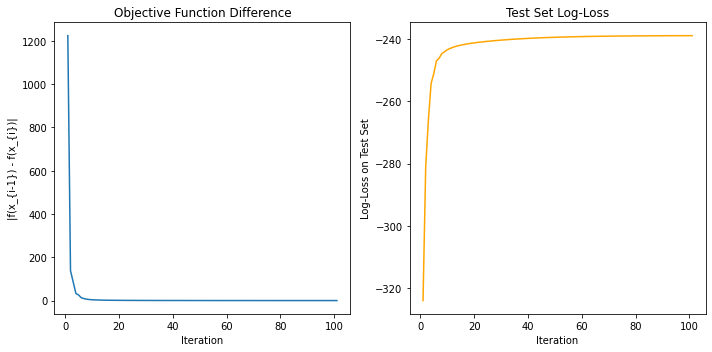

[-2.71156062  0.11618558  0.02482083  0.05253757  0.12730455  0.0396896
  0.01029799 -0.35874473 -0.27847359 -0.54623738 -0.01301301  0.03575195
  1.01979571 -0.27052503 -0.0562529   0.00627416  0.99361523  1.27688833]
0.9027624309392265


In [334]:
def compute_gradient_concave(X, y, beta):
    pred = sigmoid(X @ beta)
    return X.T @ (y - pred)

def compute_gradient_convex(X, y, beta):
    pred = sigmoid(X @ beta)
    return X.T @ (pred - y)

def maximize_ga(f, X_train, y_train, X_test, y_test, x0, tmax, epsilon):
    x = x0
    prev_f_value = f(x)
    obj_diff = []  
    test_log_losses = []
    # Learning rate is constant
    mu_i = 0.0009
    for epoch in range(tmax):
        grad = compute_gradient_concave(X_train, y_train, x)
        
        x += mu_i * grad
     
        current_f_value = f(x)
        diff = abs(current_f_value - prev_f_value)
        obj_diff.append(diff)
        
        test_log_loss = log_likelihood(X_test, y_test, x)
        test_log_losses.append(test_log_loss)
        
        if diff < epsilon:
            return x, obj_diff, test_log_losses

        prev_f_value = current_f_value

    print("Not converged in tmax iterations")
    return x, obj_diff, test_log_losses

def learn_logreg_ga(X_train, y_train, X_test, y_test,  tmax, epsilon):
    M = X_train.shape[1]
    
    beta_init = np.zeros(M)
    
    def obj_function(beta):
        return log_likelihood(X_train, y_train, beta)
    
   
    beta_hat, obj_diff, test_log_losses = maximize_ga(obj_function, X_train, y_train, X_test, y_test, beta_init,  tmax, epsilon)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(obj_diff) + 1), obj_diff)
    plt.xlabel('Iteration')
    plt.ylabel('|f(x_{i-1}) - f(x_{i})|')
    plt.title('Objective Function Difference')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_log_losses) + 1), test_log_losses, color="orange")
    plt.xlabel('Iteration')
    plt.ylabel('Log-Loss on Test Set')
    plt.title('Test Set Log-Loss')

    plt.tight_layout()
    plt.show()

    return beta_hat

def predict(X, beta):
    probabilities = sigmoid(np.dot(X, beta))
    return (probabilities >= 0.5).astype(int)

beta_hat = learn_logreg_ga(bank_Xtrain, bank_Ytrain, bank_Xtest, bank_Ytest, 1000, 1e-2)
y_pred_ga = predict(bank_Xtest, beta_hat)
print(beta_hat)
print(accuracy_score(y_pred_ga,bank_Ytest))

## Algorithm 2: minimize-Newton

**Input:** Function $ f : \mathbb{R}^N \rightarrow \mathbb{R} $, starting point $ x^{(0)} \in \mathbb{R}^N $, step length $ \mu $, maximum iterations $ t_{\text{max}} $, tolerance $ \epsilon $

1. For $ t = 1 $ to $ t_{\text{max}} $:
    1. Compute gradient $ g := \nabla f(x^{(t-1)}) $ 
    2. Compute Hessian $ H := \nabla^2 f(x^{(t-1)}) $  
    3. Update $ x^{(t)} := x^{(t-1)} - \mu H^{-1} g $  
    4. If $ f(x^{(t-1)}) - f(x^{(t)}) < \epsilon $, then:
         Return $ x^{(t)} $
2. Raise exception: "not converged in $ t_{\text{max}} $ iterations"

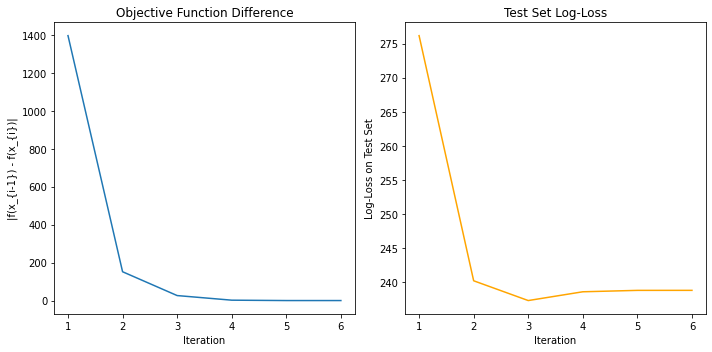

[-2.71814911e+00  1.15569211e-01  2.57693959e-02  5.23654111e-02
  1.27316213e-01  4.02498580e-02  1.02727505e-02 -3.54132650e-01
 -2.77423554e-01 -5.46151136e-01 -1.42833586e-02  3.54007340e-02
  1.02236207e+00 -2.69284759e-01 -7.01139062e-02 -1.64537238e-03
  1.06701746e+00  1.36131006e+00]
0.9038674033149171


In [335]:
def compute_hessian_convex(X, beta):
    pred = sigmoid(X @ beta)
    W = np.diag(pred * (1 - pred))
    
    return X.T @ W @ X

def minimize_newton(f, X_train, y_train, X_test, y_test, x0, tmax, epsilon):
    x = x0
    prev_f_value = f(x)
    mu_i = 1
    obj_diff = []  
    test_log_losses = []

    for epoch in range(tmax):
       
        g = compute_gradient_convex(X_train, y_train, x)
        H = compute_hessian_convex(X_train, x)
        
        x_new = x - mu_i * np.linalg.solve(H,g)

        current_f_value = f(x_new)
        
        diff = abs(current_f_value - prev_f_value)
       
        obj_diff.append(diff)

        test_log_loss = -log_likelihood(X_test, y_test, x_new)
    
        test_log_losses.append(test_log_loss)

        if diff < epsilon:
            return x_new, obj_diff, test_log_losses

        prev_f_value = current_f_value
        x = x_new

    print("Not converged in tmax iterations")
    return x, obj_diff, test_log_losses


def learn_logreg_newton(X_train, y_train, X_test, y_test,  tmax, epsilon):
    M = X_train.shape[1]
    beta_init = np.zeros(M)
    
    def obj_function(beta):
        return -log_likelihood(X_train, y_train, beta)

    beta_hat, obj_diff, test_log_losses = minimize_newton(obj_function, X_train, y_train, X_test, y_test, beta_init, tmax, epsilon)
    
    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(obj_diff) + 1), obj_diff)
    plt.xlabel('Iteration')
    plt.ylabel('|f(x_{i-1}) - f(x_{i})|')
    plt.title('Objective Function Difference')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_log_losses) + 1), test_log_losses, color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Loss on Test Set')
    plt.title('Test Set Log-Loss')

    plt.tight_layout()
    plt.show()

    return beta_hat

beta_hat = learn_logreg_newton(bank_Xtrain, bank_Ytrain, bank_Xtest, bank_Ytest, 1000, 1e-2)
y_pred_ga = predict(bank_Xtest, beta_hat)
print(beta_hat)
print(accuracy_score(y_pred_ga,bank_Ytest))

Using both gradient ascent and gradient descent with Netwon's method proved to be very accurate and fast. Newton's method produces higher accuracy, which is equal to the sklearn's LogisticRegression accuracy. The gradient descent optimization method isn't a closed form solution. This is the reason to get different coefficients and intercept from the different methods.

In [336]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
   
model.fit(bank_Xtrain, bank_Ytrain)
coefficients = model.coef_        
intercept = model.intercept_       

print("Coefficients:", coefficients)
print("Intercept:", intercept)

y_pred = model.predict(bank_Xtest)
accuracy = accuracy_score(y_pred, bank_Ytest)
accuracy

Coefficients: [[ 2.73949988e-04  1.15399804e-01  2.54865696e-02  5.21857135e-02
   1.26903637e-01  3.97744651e-02  1.04521027e-02 -3.54549181e-01
  -2.75899000e-01 -5.41815749e-01 -1.37570412e-02  3.46379225e-02
   1.01735009e+00 -2.66990018e-01 -6.39040984e-02  2.28277383e-03
   1.02829758e+00  1.31814734e+00]]
Intercept: [-2.71061919]


0.9038674033149171

## Algorithm 5: Stochastic Gradient Descent (SGD)

**Input:** Objective function $ f(\theta; x, y) $, initial parameters $ \theta^{(0)} $, learning rate $ \eta $, maximum number of epochs $ t_{\text{max}} $, tolerance $ \epsilon $, training data $ \{(x_1, y_1), (x_2, y_2), \ldots, (x_N, y_N)\} $

1. Initialize $ \theta := \theta^{(0)} $
2. For epoch = 1 to $ t_{\text{max}} $:
    1. Shuffle the training data
    2. For each training example $ (x_i, y_i) $:
        1. Compute the gradient of the loss with respect to $ \theta $ for $ (x_i, y_i) $:
           $ g := \nabla f(\theta; x_i, y_i) $
        2. Update parameters:
           $ \theta := \theta - \eta \cdot g $
    3. If convergence criterion is met (e.g., $ \|\eta \cdot g\| < \epsilon$ ), then: Return $ \theta $
3. Raise exception: "not converged in $ t_{\text{max}} $ epochs"

**Note**: In the task wasn't mentioned which Bold Driver step length algorithm should be used. I decided to use this one, since it proved better convergence speed: https://www.ismll.uni-hildesheim.de/lehre/opt-16w/script/mot-03_sgd.pdf 

Converged in epoch 11


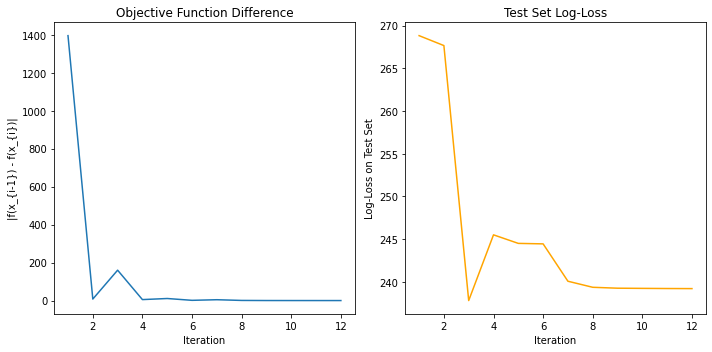

[-2.73499222e+00  1.04561155e-01  2.98201516e-02  5.35906535e-02
  1.19596080e-01  4.29977876e-02  1.10112764e-03 -3.58162502e-01
 -2.88503940e-01 -5.60215278e-01 -1.42474045e-02  3.03319979e-02
  1.02464565e+00 -2.61817026e-01 -8.97048798e-02 -5.28790354e-03
  1.15178667e+00  1.45707392e+00]
0.9038674033149171


In [ ]:
def grad_single(theta, xi, yi):
    z = np.dot(theta, xi)
    pred = sigmoid(z)
    return (pred - yi) * xi

def stochastic_gradient_descent(f, beta_init, tmax, epsilon, X, y, X_test, y_test,):
    beta = beta_init.copy()
    n_samples = len(y)

    alpha = 0.1
    obj_diff = []  
    test_log_losses = []  

    prev_f_value = f(beta)

    for epoch in range(tmax):
        indices = np.random.permutation(n_samples) 
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(n_samples):
            X_batch = X_shuffled[i]
            y_batch = y_shuffled[i]
            
            g = -grad_single(beta, X_batch, y_batch)
            beta += alpha * g
            
        current_f_value = f(beta)
        
        if current_f_value < prev_f_value:
            alpha*=0.5
        else: 
            alpha*=1.1
       
        diff = abs(current_f_value - prev_f_value)
        obj_diff.append(diff)
        
        test_log_loss = -log_likelihood(X_test, y_test, beta)
        test_log_losses.append(test_log_loss)

        if diff < epsilon:
            print(f"Converged in epoch {epoch}")
            return beta, obj_diff, test_log_losses
        
        prev_f_value = current_f_value

    print("Not converged in tmax epochs")
    return beta, obj_diff, test_log_losses

def logistic_regression_sgd(X_train, y_train, X_test, y_test, tmax, epsilon):
    M = X_train.shape[1]  
    beta_init = np.zeros(M)

    # Run SGD
    beta_hat, obj_diff, test_log_losses = stochastic_gradient_descent(
        lambda beta: -log_likelihood(X_train, y_train, beta), 
        beta_init, 
        tmax, 
        epsilon, 
        X_train, 
        y_train,
        X_test,
        y_test
    )

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(obj_diff) + 1), obj_diff)
    plt.xlabel('Iteration')
    plt.ylabel('|f(x_{i-1}) - f(x_{i})|')
    plt.title('Objective Function Difference')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_log_losses) + 1), test_log_losses, color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Loss on Test Set')
    plt.title('Test Set Log-Loss')

    plt.tight_layout()
    plt.show()

    return beta_hat

beta_hat = logistic_regression_sgd(bank_Xtrain, bank_Ytrain, bank_Xtest, bank_Ytest, 1000, 1e-2)
y_pred_sgd = predict(bank_Xtest, beta_hat)
print(beta_hat)
print(accuracy_score(y_pred_sgd, bank_Ytest))

In the task wasn't exactly specified which AdaGrad implementation to use. I found this one and it proved to be useful.

**Input:** Initial learning rate $ \eta $, gradient $ g $, accumulated squared gradients $ G $, small constant $ \epsilon $

1. $G := G + g^2$
2. $\text{adjusted\_lr} := \frac{\eta}{\sqrt{G} + \epsilon}$
3. Return $\text{adjusted\_lr}$, $ G $

**Note**: $\epsilon$ is added so we don't devide by zero if $\sqrt{G}$ = 0

Converged in epoch 63


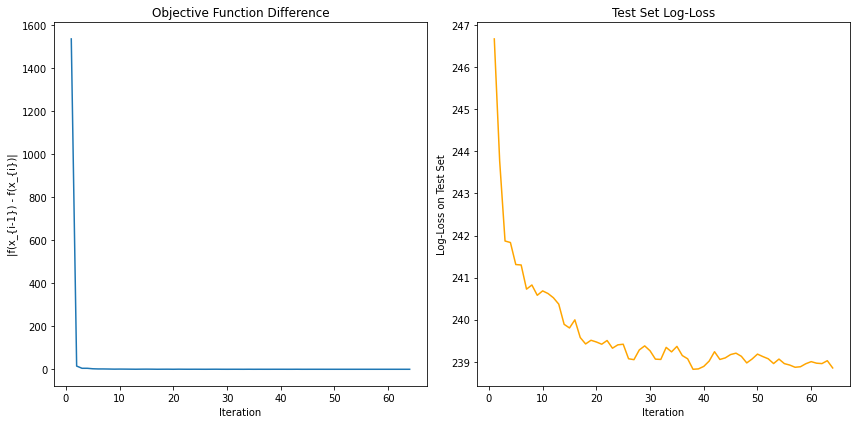

[-2.70809002  0.11673908  0.02539037  0.05145231  0.12689005  0.03833032
  0.00978981 -0.36267208 -0.2793125  -0.54669405 -0.01165034  0.03525479
  1.01868358 -0.26909358 -0.04801937  0.00848596  0.9540495   1.22228031]
0.9027624309392265


In [338]:
def adagrad_step_length(learning_rate, g, G, epsilon=1e-8):
    G += g**2
    adjusted_lr = learning_rate / (np.sqrt(G) + epsilon) 
    return adjusted_lr, G

def stochastic_gradient_descent_adagrad(f, beta_init, learning_rate, tmax, epsilon, X, y, X_test, y_test, batch_size=1):
    beta = beta_init.copy()
    n_samples = len(y)
    G = np.zeros_like(beta) 
    
    obj_diff = []  
    test_log_losses = []  
    
    prev_f_value = f(beta)

    for epoch in range(tmax):
        indices = np.random.permutation(n_samples) 
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(n_samples):
           X_batch = X_shuffled[i]
           y_batch = y_shuffled[i]
           g = grad_single(beta, X_batch, y_batch) 
           adjusted_lr, G = adagrad_step_length(learning_rate, g, G)
           beta -= adjusted_lr * g

        current_f_value = f(beta)
        diff = abs(current_f_value - prev_f_value)
        obj_diff.append(diff)

        test_log_loss = -log_likelihood(X_test, y_test, beta) 
        test_log_losses.append(test_log_loss)
        if  diff < epsilon:
            print(f"Converged in epoch {epoch}")
            return beta, obj_diff, test_log_losses

        prev_f_value = current_f_value
        

    print("Not converged in tmax epochs")
    return beta, obj_diff, test_log_losses

def logistic_regression_sgd_adagrad(X_train, y_train, X_test, y_test, learning_rate, tmax, epsilon):
    M = X_train.shape[1]
    beta_init = np.zeros(M)

    # Run SGD with AdaGrad
    beta_hat, obj_diff, test_log_losses = stochastic_gradient_descent_adagrad(
        lambda beta: -log_likelihood(X_train, y_train, beta),
        beta_init,
        learning_rate, 
        tmax, epsilon,
        X_train, 
        y_train,
        X_test, 
        y_test
    )

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(obj_diff) + 1), obj_diff)
    plt.xlabel('Iteration')
    plt.ylabel('|f(x_{i-1}) - f(x_{i})|')
    plt.title('Objective Function Difference')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_log_losses) + 1), test_log_losses, color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Loss on Test Set')
    plt.title('Test Set Log-Loss')

    plt.tight_layout()
    plt.show()

    return beta_hat

beta_hat = logistic_regression_sgd_adagrad(
    bank_Xtrain, 
    bank_Ytrain, 
    bank_Xtest, 
    bank_Ytest, 
    learning_rate=0.1, 
    tmax=1000, 
    epsilon=1e-2
)

y_pred_ada = predict(bank_Xtest, beta_hat)
print(beta_hat)
print(accuracy_score(y_pred_ada, bank_Ytest))

In [339]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log', max_iter=100)

bank_Xtrain = bank_Xtrain[:, 1:]
bank_Xtest = bank_Xtest[:, 1:]
sgd_model.fit(bank_Xtrain, bank_Ytrain)  
print(accuracy_score(bank_Ytest, sgd_model.predict(bank_Xtest)))
print(sgd_model.coef_)
print(sgd_model.intercept_)

0.8972375690607735
[[ 0.22238966 -0.02220681  0.14353597  0.18199706 -0.18862741  0.10849482
  -0.63711893 -0.40656871 -0.35224169  0.09299495 -0.31784172  1.28438918
  -0.19444949 -0.24735728 -0.10779457  1.3109211   1.50124878]]
[-3.0049617]


Stochastic Gradient Descent (SGD) produces great results with both AdaGrad and Bold Driver step length algorithm. They are both very near to the sklearn's SGDClassfier accuaracy.

#### **Analysis of the results**

As we can see the graphs of logistic regression with SGD aren't as smooth as the one of logistic regression with batch gradient descent/ascent. This is because we dont' use the whole data to compute the gradient at once but we evaluate the gradient for each sample individually. However, the SGD versions of the logistic regression still converges to a relatively accurate solution. They aren't the same everytime, which is one of the problems of the SGD.

When we have smaller dataset we can see that batch gradient descent/ascent performs faster. A situation where SGD would be useful is, when we have a big dataset which can't fit in the main memory. It's computationally more performant and sometimes even the only choice.